<a href="https://colab.research.google.com/github/CorpuzKB/PML-Advance-Topics-notebooks/blob/main/HMM_Inference__TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hidden Markov Model (HMM) State Inference
The **HMM_Categorical_Inference** class includes the methods listed below that are capable of inferring from batched samples and are implemented from the book, [Probabilistic Machine Learning: Advanced Topics (Murphy K., 2023)](https://probml.github.io/pml-book/book2.html):
1.   Forward-Backwards algorithm
2.   The Viterbi algorithm

The current implementation is limited to HMM with discrete observed likelihood.

In [1]:
!pip install tqdm -q

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
from tqdm import tqdm

tfd = tfp.distributions
sns.set(rc={"figure.dpi":80, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
set_matplotlib_formats('retina')

In [2]:
class HMM_Categorical_Inference:
  def __init__(self, transition_matrix, observation_matrix, states_0, observations):
    local_evidence = tf.gather(observation_matrix, observations, axis=1)
    self.local_evidence = tf.transpose(local_evidence, [1, 2, 0])[..., tf.newaxis]
    self.batch_dims = self.local_evidence.shape[0]
    self.num_steps = self.local_evidence.shape[1]
    self.transition_matrix = transition_matrix
    self.states_0 = states_0
    self.num_states = transition_matrix.shape[0]

  def normalizing_constant(self, x):
    return (tf.reduce_sum(x, -2, keepdims=True))

  def Forward(self):
    a_t = self.states_0
    for i in tqdm(range(self.num_steps)):
      a_t = self.local_evidence[:, i] * (tf.transpose(self.transition_matrix) @ a_t)
      Z_t = self.normalizing_constant(a_t)
      a_t = a_t / Z_t
      if i == 0: 
        a = a_t
        Z = Z_t
      else: 
        a = tf.concat([a, a_t], 2)
        Z = tf.concat([Z, Z_t], 1)
    return tf.transpose(a, [0, 2, 1])[..., tf.newaxis], Z

  def Backward(self, a, a_Z):
    β = tf.fill([self.batch_dims, self.num_states, 1], 1.)
    β_t = β
    for i in tqdm(range(self.num_steps - 1, -1, -1)):
      β_t = self.transition_matrix @ (self.local_evidence[:, i] * β_t)
      β_t = β_t / a_Z[:, i][..., tf.newaxis]
      β = tf.concat([β, β_t], 2)    
    β = tf.reverse(β[..., :-1], [-1])
    β = tf.transpose(β, [0, 2, 1])[..., tf.newaxis]
    g = a * β
    g = g / self.normalizing_constant(g)
    return g, β

  def TwoSlice_Marginals(self, a, β):
    a = a[:, :(self.num_steps-1)]
    β = β[:, 1:]
    λ = self.local_evidence[:, 1:]
    ξ = self.transition_matrix * (a @ tf.transpose(λ * β, [0, 1, 3, 2]) )
    K = tf.reduce_sum(tf.reduce_sum(ξ, -1), -1, keepdims=True)
    ξ = ξ / tf.broadcast_to(K[..., tf.newaxis], ξ.shape)
    return ξ

  def Viterbi(self):
    δ_t = - tf.math.log(self.local_evidence[:, 0]) - tf.math.log(self.states_0)
    λ = - tf.math.log(tf.transpose(self.local_evidence, [0, 1, 3, 2]))
    λ = tf.tile(λ, [1, self.batch_dims, self.num_states, 1]) 
    A = - tf.math.log(tf.transpose(self.transition_matrix))
    for i in tqdm(range(1, self.num_steps)):
      δ_ = A + λ[:, i] + tf.tile(tf.transpose(δ_t, [0, 2, 1]), [1, self.num_states, 1])
      min_index = tf.math.argmin(δ_, 2)[..., tf.newaxis]
      δ_t = tf.gather_nd(δ_, min_index, 2)[..., tf.newaxis]
      if i == 1: 
        node = min_index
      else: 
        node = tf.concat([node, min_index], 2)
    node = tf.transpose(node, [0, 2, 1])
    state_t = tf.math.argmin(tf.reshape(δ_, [self.batch_dims, self.num_states * self.num_states]), 1)
    state_t = tf.cast(state_t/self.num_states, tf.int64)[..., tf.newaxis]
    MAP_path = state_t
    for i in range(self.num_steps - 2, -1, -1):
      state_t = tf.gather(node[:, i], state_t[..., 0], axis=1, batch_dims=1)[..., tf.newaxis]
      MAP_path = tf.concat([MAP_path, state_t], 1)
    return tf.reverse(MAP_path, [-1])

## Casino Dice Roll State Inference

### Generate Sample Data

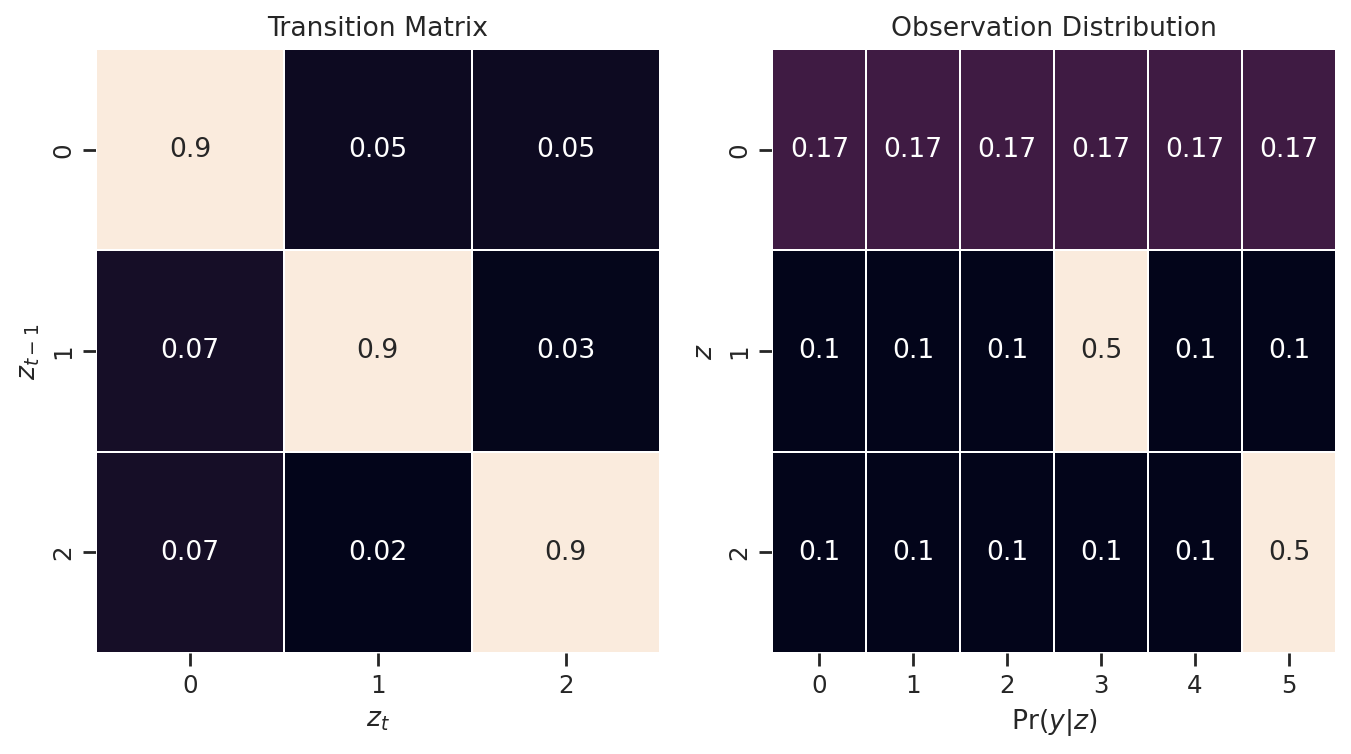

In [3]:
num_states = 3

states_0 = tf.fill([num_states, 1], 1/num_states)
A = tf.constant([
    [0.90, 0.05, 0.05], 
    [0.07, 0.9, 0.03],
    [0.07, 0.02, 0.9]
])

λ = tf.stack([
    tf.squeeze(tf.constant(tf.fill([1, 6], 1/6))),
    tf.constant([1/10, 1/10, 1/10, 5/10, 1/10, 1/10]),
    tf.constant([*[1/10 for _ in range(5)], 5/10])
    ])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(A, annot=True, linewidth=.5, ax=axes[0], cbar=False)
sns.heatmap(λ, annot=True, linewidth=.5, ax=axes[1], cbar=False)
axes[0].set(xlabel='$z_{t}$', ylabel='$z_{t-1}$', title='Transition Matrix')
axes[1].set(xlabel='$\Pr(y|z)$', ylabel='$z$', title='Observation Distribution')
plt.show()

In [4]:
def CasinoHMM(A, B, π, steps, batch_dims=1):
  state_t = tfd.Categorical(probs=tf.squeeze(π)).sample([batch_dims, 1])
  transition_distribution = tfd.Categorical(probs=A).sample([batch_dims, steps])
  observation_distribution = tfd.Categorical(probs=B).sample([batch_dims, steps])
  for i in range(steps):
    state_t = tf.gather_nd(transition_distribution[:, i], state_t, 1)[:, tf.newaxis]
    obs_t = tf.gather_nd(observation_distribution[:, i], state_t, 1)[:, tf.newaxis]
    if i == 0: 
      state = state_t
      obs = obs_t
    else: 
      state = tf.concat([state, state_t], 1)
      obs = tf.concat([obs, obs_t], 1)
  return state, obs

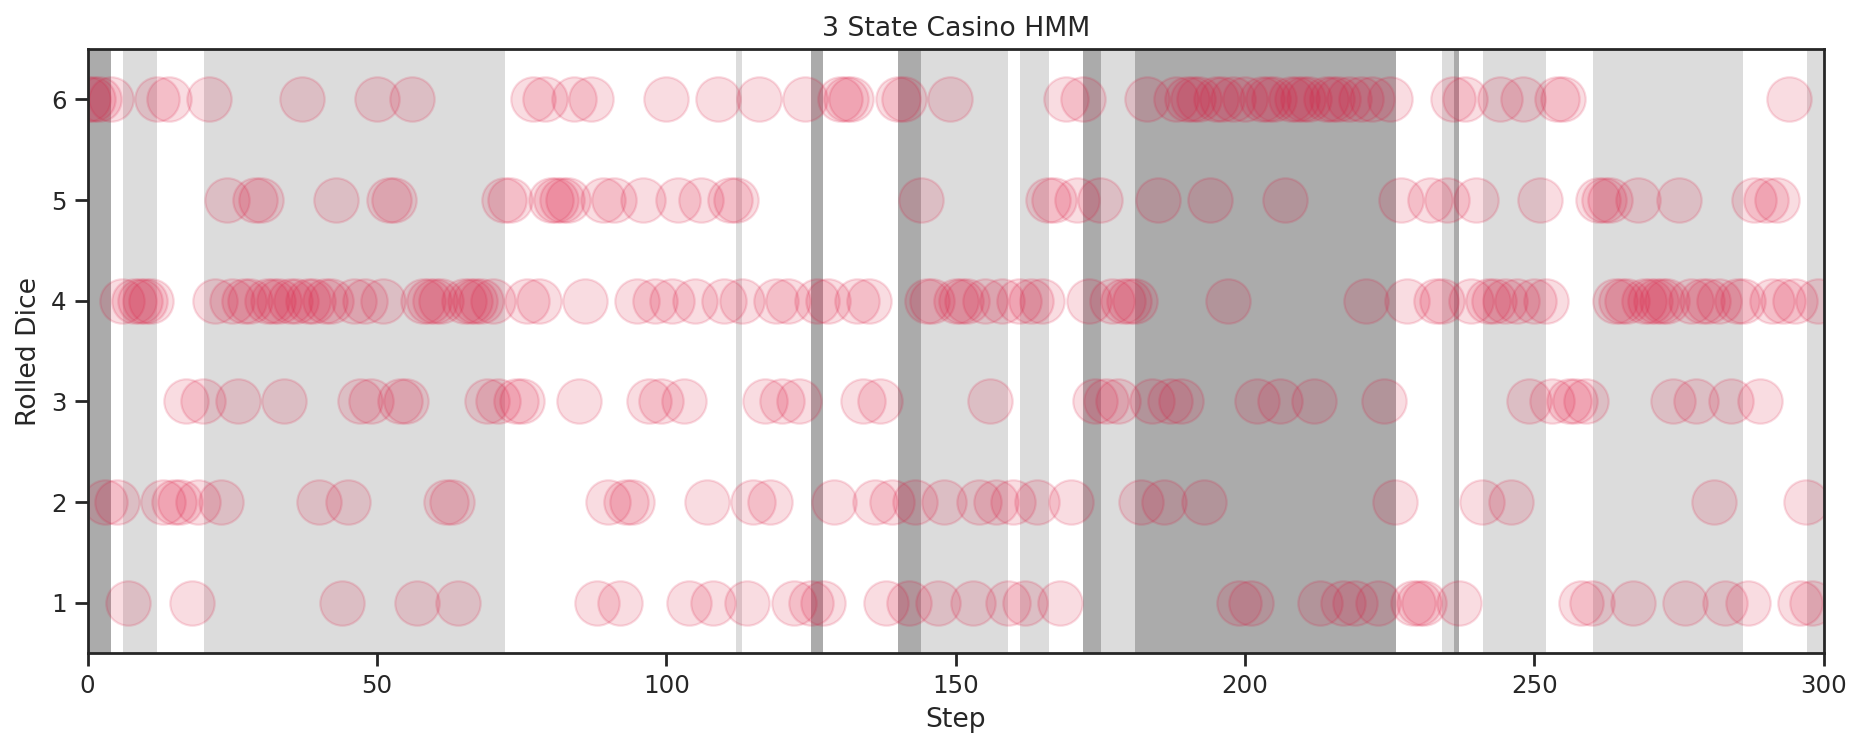

In [16]:
num_batches = 1
num_steps = 300
true_states, observations = CasinoHMM(A, λ, states_0, num_steps, batch_dims=num_batches)
plt.figure(figsize=(14, 5))
plt.imshow(true_states[None, 0, :], extent=(0, num_steps, 0, 7), cmap='Greys', alpha=0.33, aspect='auto')
plt.scatter(tf.range(num_steps), observations[0] + 1, color="crimson", alpha=0.15, s=400)
plt.title("{} State Casino HMM".format(num_states)); plt.ylabel('Rolled Dice');  plt.xlabel('Step'); plt.ylim(0.5, 6.5); plt.show()

### Perform Inference

In [17]:
Inference = HMM_Categorical_Inference(A, λ, states_0, observations)
prob_filtered, Z_filtered= Inference.Forward()
prob_smoothed, β = Inference.Backward(prob_filtered, Z_filtered)
states_Viterbi = Inference.Viterbi()

100%|██████████| 299/299 [00:01<00:00, 210.25it/s]


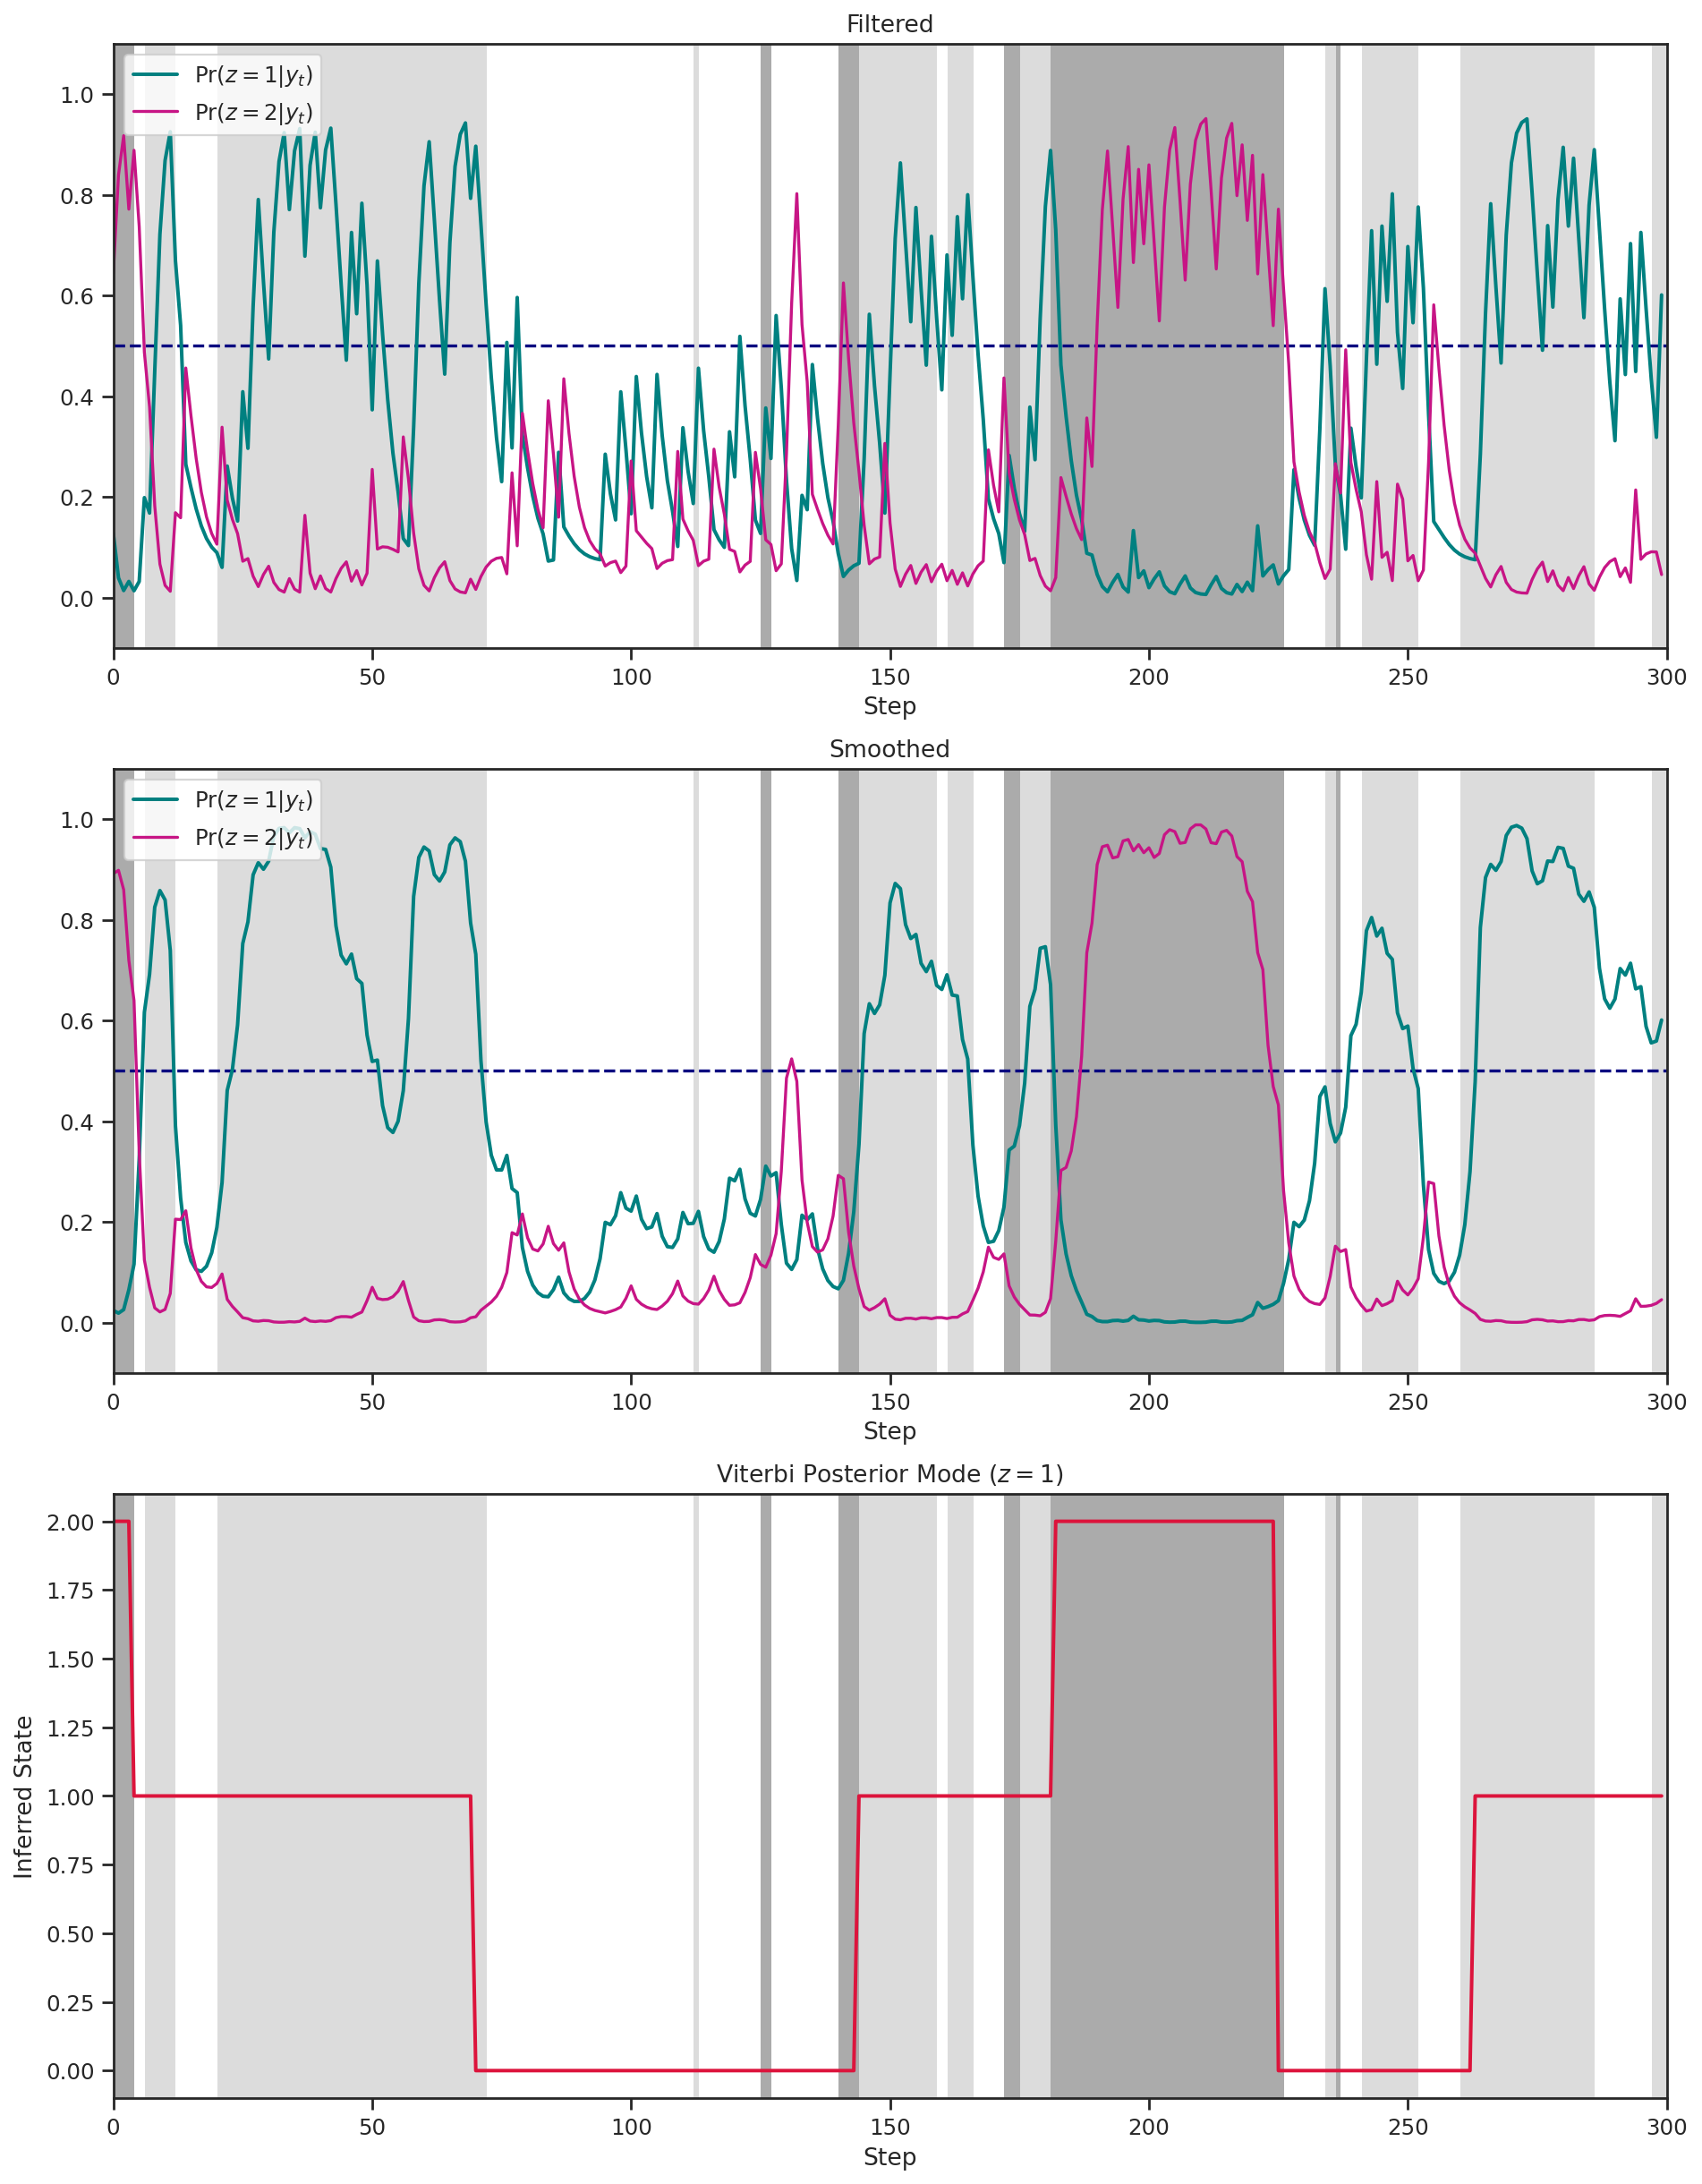

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(14, 19))
title = ['Filtered', 'Smoothed', "Viterbi Posterior Mode ($z=1$)"]
data = [prob_filtered[0, :, 1], prob_filtered[0, :, 2], 
        prob_smoothed[0, :, 1], prob_smoothed[0, :, 2]]

for i in range(2):
  axes[i].imshow(true_states[None, 0, :], extent=(0, num_steps, -0.1, 1.1), cmap='Greys', alpha=0.33, aspect='auto')
  axes[i].axhline(0.5, color = 'navy', linestyle='--')
  axes[i].plot(data[2*i], label='$\Pr(z=1|y_t)$', color='teal', linewidth=1.8)
  axes[i].plot(data[2*i + 1], label='$\Pr(z=2|y_t)$', color='mediumvioletred', linewidth=1.5)
  axes[i].set(xlabel='Step', title=title[i])
  axes[i].legend(loc='upper left');

axes[2].plot(states_Viterbi[0, :], color='crimson', linewidth=1.8)
axes[2].imshow(true_states[None, 0, :], extent=(0, num_steps, -0.1, num_states - 0.9), cmap='Greys', alpha=0.33, aspect='auto')
axes[2].set(xlabel='Step', ylabel='Inferred State', title='Viterbi Posterior Mode ($z=1$)')
plt.show()